## Experiments for Assignment 2 - GTSRB competition on Kaggle
#### Rohan M - rm5310
##### Name on Kaggle leaderboard - RohanM
This is meant to be read after the `1. EDA.ipynb` notebook, which details the data exploratory experiments I did before training the models for this competition. 

All the models mentioned in this notebook can be accessed here - https://drive.google.com/drive/folders/1wqqwIT-oLk92OaELVUguBGSBmzwXYv6W?usp=sharing

Once downloaded, you can save them in a directory called `Models/` to run this notebook

These are just the experiments around the final models which gave me good results. I have removed the cells which pertained to the many many bad models I made for this competition. At the time of writing, I had the most number of submissions so it would be fair to say that I had a lot of failed experiments. 

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from tqdm import tqdm
import os
import PIL.Image as Image

import torchvision
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts

from model import MultiScaleCNN, AdaptiveMultiScaleCNN, Conv4Net

device = torch.device('cuda')

from data import initialize_data, training_transforms, test_transforms # data.py in the same folder
initialize_data('images/') # extracts the zip files, makes a validation set

#### This is a helper function based on the previous notebook which returns a data loader with the augmentations we decided for a particular size. I am going to be using the sizes 32, 50 and 70px as mentioned in the previous notebook.

In [2]:
def get_data(size):
    t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11 = get_transforms(size)
    train_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([
        datasets.ImageFolder('images/train_images', transform=t0),
        datasets.ImageFolder('images/train_images', transform=t1),
        datasets.ImageFolder('images/train_images', transform=t2),
        datasets.ImageFolder('images/train_images', transform=t3),
        datasets.ImageFolder('images/train_images', transform=t4),
        datasets.ImageFolder('images/train_images', transform=t5),
        datasets.ImageFolder('images/train_images', transform=t6),
        datasets.ImageFolder('images/train_images', transform=t7),
        datasets.ImageFolder('images/train_images', transform=t8),
        datasets.ImageFolder('images/train_images', transform=t9),
        datasets.ImageFolder('images/train_images', transform=t10),
    ]),
    batch_size=1024, shuffle=True, num_workers = 8)

    val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder('images/val_images', transform=t0),
        batch_size=1024, shuffle=False, num_workers = 8)
    
    return train_loader, val_loader    
    
    
# Get all the possible transforms for a given size.
def get_transforms(size):
    # Keep the same
    t0 = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
    ])

    # Scale brightness between the range (1.5,3.5)
    t1 = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ColorJitter(brightness=2.5),
        transforms.ToTensor(),
        transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
    ])

    # Scale saturation between (1,2)
    t2 = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ColorJitter(saturation=2),
        transforms.ToTensor(),
        transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
    ])

    # Scale contrast between (1,1.5)
    t3 = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ColorJitter(contrast=1.5),
        transforms.ToTensor(),
        transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
    ])

    # Scale hue
    t4 = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ColorJitter(hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
    ])

    # Random horizontal flips
    t5 = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
    ])

    # Random shearing
    t6 = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomAffine(degrees=20, shear=3),
        transforms.ToTensor(),
        transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
    ])

    # Random Translation
    t7 = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomAffine(degrees=10, translate=(0.2,0.2)),
        transforms.ToTensor(),
        transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
    ])

    # Random perspective change
    t8 = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomPerspective(),
        transforms.ToTensor(),
        transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
    ])

    # Random rotation
    t9 = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
    ])

    # Upscale the image to size*1.5 then make a random crop of size=size
    t10 = transforms.Compose([
        transforms.Resize((int(size*1.5), int(size*1.5))),
        transforms.RandomResizedCrop(size=size),
        transforms.ToTensor(),
        transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
    ])

    # TenCrop, only used in TTA
    t11 = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.TenCrop(size),
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        transforms.Lambda(lambda crops: torch.stack([transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))(crop) for crop in crops])),
    ])
    
    return t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11

#### These are the generic train and validate functions which I used directly based on the template codebase - https://github.com/soumith/traffic-sign-detection-homework

In [6]:
def train(train_loader, epoch, model, optimizer, sched):
    model.train()
    iters = len(train_loader)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        sched.step(epoch + batch_idx/iters)
        model.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation(val_loader, model):
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = Variable(data).to(device), Variable(target).to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

In [11]:
def train_loop(model, train_dl, val_dl, optimizer, sched, epochs, exp_name):
    for epoch in range(1, epochs + 1):
        train(train_dl, epoch, model, optimizer, sched)
        validation(val_dl, model)
        if epoch%(epochs//2) == 0:
            model_file = 'Models/' + exp_name + str(epoch) + '.pth'
            torch.save(model.state_dict(), model_file)
            print('\nSaved model to Models/' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file')

### This imports the Multi-scale CNN architecture I wrote (found in `model.py`) based on the paper - http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

#### The idea behind this model is to concatenate features from multiple convolutional blocks so that features from earlier blocks can also be used in a more prevalent manner in the classification task.

Essentially the model looks like this:

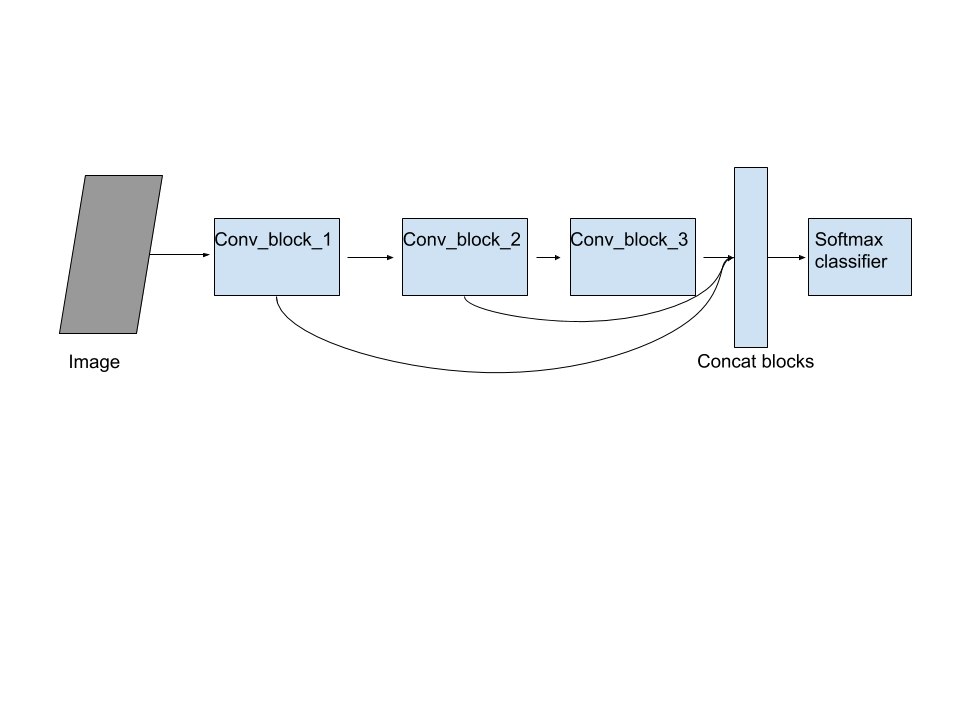

In [5]:
from IPython.display import Image
Image(filename='Model.png') 

In [3]:
mcnn = MultiScaleCNN().to(device)

### I use the Adam optimizer for training. After experimenting with SGD and ADAMW and ADAGRAD. I found this to be the most stable and got consistent results. 
(Again, not including all my experiment cells for brevity).

In [5]:
optimizer = torch.optim.Adam(mcnn.parameters())
sched = CosineAnnealingWarmRestarts(optimizer, T_0=1)
epochs = 100
exp_name = 'mcnn42_aug_500_'

### Along with that I use Cosine Annealing with warm restarts which I found to work best amongst OneCycle learning, no schedulers and simply cosine annealing without restarts.

In [13]:
for epoch in range(1, epochs + 1):
    train(epoch, mcnn, optimizer, sched)
    validation(mcnn)
    if epoch%50 == 0:
        model_file = exp_name + str(epoch) + '.pth'
        torch.save(mcnn.state_dict(), model_file)
        print('\nSaved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file')

Train Epoch: 1 [0/353390 (0%)]	Loss: 3.761759
Train Epoch: 1 [10240/353390 (3%)]	Loss: 3.409454
Train Epoch: 1 [20480/353390 (6%)]	Loss: 3.137361
Train Epoch: 1 [30720/353390 (9%)]	Loss: 2.782789
Train Epoch: 1 [40960/353390 (12%)]	Loss: 2.337990
Train Epoch: 1 [51200/353390 (14%)]	Loss: 1.992156
Train Epoch: 1 [61440/353390 (17%)]	Loss: 1.935070
Train Epoch: 1 [71680/353390 (20%)]	Loss: 1.652224
Train Epoch: 1 [81920/353390 (23%)]	Loss: 1.567037
Train Epoch: 1 [92160/353390 (26%)]	Loss: 1.433980
Train Epoch: 1 [102400/353390 (29%)]	Loss: 1.222073
Train Epoch: 1 [112640/353390 (32%)]	Loss: 1.159396
Train Epoch: 1 [122880/353390 (35%)]	Loss: 1.143262
Train Epoch: 1 [133120/353390 (38%)]	Loss: 0.989242
Train Epoch: 1 [143360/353390 (40%)]	Loss: 0.904658
Train Epoch: 1 [153600/353390 (43%)]	Loss: 0.933700
Train Epoch: 1 [163840/353390 (46%)]	Loss: 0.811260
Train Epoch: 1 [174080/353390 (49%)]	Loss: 0.772634
Train Epoch: 1 [184320/353390 (52%)]	Loss: 0.893101
Train Epoch: 1 [194560/353390 

Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=RGB size=34x36 at 0x2B29555525C0>>
Traceback (most recent call last):
  File "/home/rm5310/pyenv/py3.6.3/lib/python3.6/site-packages/PIL/Image.py", line 634, in __del__
    self.__exit__()
  File "/home/rm5310/pyenv/py3.6.3/lib/python3.6/site-packages/PIL/Image.py", line 596, in __exit__
    if hasattr(self, "fp") and getattr(self, "_exclusive_fp", False):
KeyboardInterrupt


KeyboardInterrupt: 

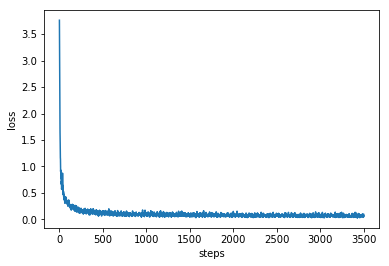

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
with open("mcnn_loss.txt") as f:
    train_losses = []
    a = [line.split() for line in f]
    for l in range(len(a)):
        if len(a[l]) > 0:
            if (a[l][0] == 'Train'):
                train_losses.append(float(a[l][-1]))
plt.plot(train_losses)
plt.ylabel('loss')
plt.xlabel('steps')
plt.show()              

#### This model is trained for 100 epochs and converges pretty well in that period. So now we try to evaluate this model on the test set and submit our scores to Kaggle.

## Eval

In [6]:
state_dict = torch.load('Models/mcnn42_aug_500_100.pth')
mcnn.load_state_dict(state_dict)
mcnn.eval()
exp_name = 'mcnn42_tta_aug_500_100'

In [7]:
t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t210,t211 = get_transforms(32)

test_dir = 'images/test_images'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

outfile = 'Output/'+exp_name+'_out.csv'

output_file = open(outfile, "w")
output_file.write("Filename,ClassId\n")
for f in tqdm(os.listdir(test_dir)):
    if 'ppm' in f:
        data1 = t211(pil_loader(test_dir + '/' + f))
        data2 = t21((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data3 = t22((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data4 = t23((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data5 = t24((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data6 = t25((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data7 = t26((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data8 = t27((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data9 = t28((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data10 = t29((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data11 = t210((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data12 = t20((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        
        final_input_1 = torch.cat((data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,data11,data12),0)
         
        ntrans, c, h, w = final_input_1.size()
        temp_output = mcnn(Variable(final_input_1.view(-1, c, h, w)).to(device))
        output = temp_output.mean(0)
        pred = output.data.max(0, keepdim=True)[1]
    
        file_id = f[0:5]
        output_file.write("%s,%d\n" % (file_id, pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle '
      'competition at https://www.kaggle.com/c/nyu-cv-fall-2018/')
        

100%|██████████| 12630/12630 [03:19<00:00, 63.44it/s]

Succesfully wrote mcnn42_tta_aug_500_100_out.csv, you can upload this file to the kaggle competition at https://www.kaggle.com/c/nyu-cv-fall-2018/


## This model gives a test set accuracy of around 97% which is good but it can be made much better and this is the part where I feel is my biggest contribution.

## The EDA tells us that there are images of multiple sizes in our dataset, so I created a modified version of the Multi-Scale CNN called the `Adaptive Multi-scale CNN` which can train images of different sizes on the same network. The model architecture which I designed can be found in `model.py`. It essentially uses AdaptiveAvgPooling as mentioned in https://arxiv.org/pdf/1406.4729.pdf, which allows us to input images of different sizes. The basic idea is that for this kind of pooling, instead of having convolution kernels of fixed sizes, we have outputs of fixed sizes and dynamically change the kernel size based on the input.

In [4]:
amcnn = AdaptiveMultiScaleCNN().to(device)

In [7]:
train_dl, val_dl = get_data(size=32)

In [10]:
optimizer = torch.optim.Adam(amcnn.parameters())
sched = CosineAnnealingWarmRestarts(optimizer, T_0=1)
train_loop(amcnn, train_dl, val_dl, optimizer, sched, epochs=100, exp_name='amcnn1_32_')

Train Epoch: 1 [0/388729 (0%)]	Loss: 3.760471
Train Epoch: 1 [10240/388729 (3%)]	Loss: 3.312083
Train Epoch: 1 [20480/388729 (5%)]	Loss: 2.943891
Train Epoch: 1 [30720/388729 (8%)]	Loss: 2.537194
Train Epoch: 1 [40960/388729 (11%)]	Loss: 2.042018
Train Epoch: 1 [51200/388729 (13%)]	Loss: 1.916836
Train Epoch: 1 [61440/388729 (16%)]	Loss: 1.702132
Train Epoch: 1 [71680/388729 (18%)]	Loss: 1.513314
Train Epoch: 1 [81920/388729 (21%)]	Loss: 1.301051
Train Epoch: 1 [92160/388729 (24%)]	Loss: 1.177693
Train Epoch: 1 [102400/388729 (26%)]	Loss: 1.139583
Train Epoch: 1 [112640/388729 (29%)]	Loss: 1.088615
Train Epoch: 1 [122880/388729 (32%)]	Loss: 1.005194
Train Epoch: 1 [133120/388729 (34%)]	Loss: 0.883402
Train Epoch: 1 [143360/388729 (37%)]	Loss: 0.872205
Train Epoch: 1 [153600/388729 (39%)]	Loss: 0.815859
Train Epoch: 1 [163840/388729 (42%)]	Loss: 0.850296
Train Epoch: 1 [174080/388729 (45%)]	Loss: 0.832526
Train Epoch: 1 [184320/388729 (47%)]	Loss: 0.738177
Train Epoch: 1 [194560/388729 

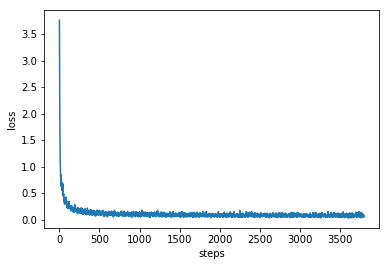

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
with open("amcnn_loss.txt") as f:
    train_losses = []
    a = [line.split() for line in f]
    for l in range(len(a)):
        if len(a[l]) > 0:
            if (a[l][0] == 'Train'):
                train_losses.append(float(a[l][-1]))
plt.plot(train_losses)
plt.ylabel('loss')
plt.xlabel('steps')
plt.show()              

In [11]:
state_dict = torch.load('Models/amcnn1_32_100.pth')
amcnn.load_state_dict(state_dict)

<All keys matched successfully>

In [12]:
train_dl, val_dl = get_data(size=50)

In [13]:
train_loop(amcnn, train_dl, val_dl, optimizer, sched, epochs=50, exp_name='amcnn1_50_')

Train Epoch: 1 [0/388729 (0%)]	Loss: 0.090048
Train Epoch: 1 [10240/388729 (3%)]	Loss: 0.088581
Train Epoch: 1 [20480/388729 (5%)]	Loss: 0.128636
Train Epoch: 1 [30720/388729 (8%)]	Loss: 0.094943
Train Epoch: 1 [40960/388729 (11%)]	Loss: 0.074820
Train Epoch: 1 [51200/388729 (13%)]	Loss: 0.099027
Train Epoch: 1 [61440/388729 (16%)]	Loss: 0.069364
Train Epoch: 1 [71680/388729 (18%)]	Loss: 0.074618
Train Epoch: 1 [81920/388729 (21%)]	Loss: 0.074193
Train Epoch: 1 [92160/388729 (24%)]	Loss: 0.067914
Train Epoch: 1 [102400/388729 (26%)]	Loss: 0.123903
Train Epoch: 1 [112640/388729 (29%)]	Loss: 0.118425
Train Epoch: 1 [122880/388729 (32%)]	Loss: 0.100210
Train Epoch: 1 [133120/388729 (34%)]	Loss: 0.084047
Train Epoch: 1 [143360/388729 (37%)]	Loss: 0.060777
Train Epoch: 1 [153600/388729 (39%)]	Loss: 0.073014
Train Epoch: 1 [163840/388729 (42%)]	Loss: 0.074101
Train Epoch: 1 [174080/388729 (45%)]	Loss: 0.102725
Train Epoch: 1 [184320/388729 (47%)]	Loss: 0.092703
Train Epoch: 1 [194560/388729 

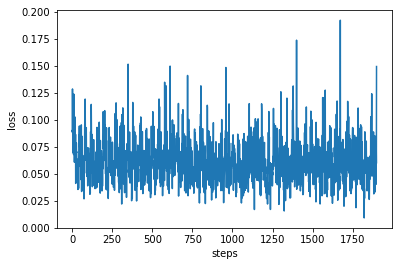

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
with open("amcnn_loss2.txt") as f:
    train_losses = []
    a = [line.split() for line in f]
    for l in range(len(a)):
        if len(a[l]) > 0:
            if (a[l][0] == 'Train'):
                train_losses.append(float(a[l][-1]))
plt.plot(train_losses)
plt.ylabel('loss')
plt.xlabel('steps')
plt.show()              

#### There are spikes here because this is the second phase of training, suggesting that this wasn't that necessary

In [14]:
state_dict = torch.load('Models/amcnn1_50_50.pth')
amcnn.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
train_dl, val_dl = get_data(size=70)

In [16]:
train_loop(amcnn, train_dl, val_dl, optimizer, sched, epochs=50, exp_name='amcnn1_70_')

Train Epoch: 1 [0/388729 (0%)]	Loss: 0.052230
Train Epoch: 1 [10240/388729 (3%)]	Loss: 0.057504
Train Epoch: 1 [20480/388729 (5%)]	Loss: 0.055668
Train Epoch: 1 [30720/388729 (8%)]	Loss: 0.064176
Train Epoch: 1 [40960/388729 (11%)]	Loss: 0.068172
Train Epoch: 1 [51200/388729 (13%)]	Loss: 0.091435
Train Epoch: 1 [61440/388729 (16%)]	Loss: 0.082223
Train Epoch: 1 [71680/388729 (18%)]	Loss: 0.060050
Train Epoch: 1 [81920/388729 (21%)]	Loss: 0.070539
Train Epoch: 1 [92160/388729 (24%)]	Loss: 0.067857
Train Epoch: 1 [102400/388729 (26%)]	Loss: 0.082673
Train Epoch: 1 [112640/388729 (29%)]	Loss: 0.053731
Train Epoch: 1 [122880/388729 (32%)]	Loss: 0.066060
Train Epoch: 1 [133120/388729 (34%)]	Loss: 0.072274
Train Epoch: 1 [143360/388729 (37%)]	Loss: 0.058351
Train Epoch: 1 [153600/388729 (39%)]	Loss: 0.075673
Train Epoch: 1 [163840/388729 (42%)]	Loss: 0.047871
Train Epoch: 1 [174080/388729 (45%)]	Loss: 0.045336
Train Epoch: 1 [184320/388729 (47%)]	Loss: 0.053851
Train Epoch: 1 [194560/388729 

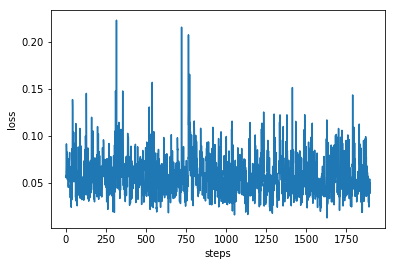

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
with open("amcnn_loss3.txt") as f:
    train_losses = []
    a = [line.split() for line in f]
    for l in range(len(a)):
        if len(a[l]) > 0:
            if (a[l][0] == 'Train'):
                train_losses.append(float(a[l][-1]))
plt.plot(train_losses)
plt.ylabel('loss')
plt.xlabel('steps')
plt.show()              

## Training this Adaptive MultiScale CNN makes us reach about 99.1% which is a big increment but adding more tricks to our evaluation will make our predictions even better.

### There is another model which I tried, which can be found in `model.py` called Conv42 which is essentially a 4 block CNN without any connection, so its more or less an  AlexNet clone with a few modifications. I'm clearing out some of the training code for that model as it is not that relevant and is making this notebook much more cluttered.

# Trick 1: Model Ensembling

### The idea behind ensembling is that you average the prediction given by multiple models so that the predictions are smooth. Here, I create an ensemble of the Conv42 model, the Multi-scale CNN model and the Adaptive Multi-Scale CNN model for sizes 32, 50 and 70px

In [3]:
state_dict_1 = torch.load('Models/conv42_aug_100_100.pth')
model1 = Conv4Net().to(device)
model1.load_state_dict(state_dict_1)
model1.eval()

state_dict_2 = torch.load('Models/mcnn42_aug_500_100.pth')
model2 = MultiScaleCNN().to(device)
model2.load_state_dict(state_dict_2)
model2.eval()

state_dict_3 = torch.load('Models/amcnn1_32_100.pth')
model3 = AdaptiveMultiScaleCNN().to(device)
model3.load_state_dict(state_dict_3)
model3.eval()

state_dict_4 = torch.load('Models/amcnn1_50_50.pth')
model4 = AdaptiveMultiScaleCNN().to(device)
model4.load_state_dict(state_dict_4)
model4.eval()

state_dict_5 = torch.load('Models/amcnn1_70_50.pth')
model5 = AdaptiveMultiScaleCNN().to(device)
model5.load_state_dict(state_dict_5)
model5.eval()

exp_name = 'committee_3'

# Trick 2: Test time augmentation

### Test time augmentation is simply the idea where instead of predicting the output on one test image, we perform data augmentation on the test image and give our prediction on all of the transformations and average the result. This will again give us a smoother prediction. Below is the code which performs the augmentations on the test images and averages the results.

In [11]:
t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11 = get_transforms(32)
t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t210,t211 = get_transforms(50)
t30,t31,t32,t33,t34,t35,t36,t37,t38,t39,t310,t311 = get_transforms(70)

test_dir = 'images/test_images'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

outfile = 'Output/'+exp_name+'_out.csv'

output_file = open(outfile, "w")
output_file.write("Filename,ClassId\n")
for f in tqdm(os.listdir(test_dir)):
    if 'ppm' in f:
        data1 = t211(pil_loader(test_dir + '/' + f))
        data2 = t21((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data3 = t22((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data4 = t23((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data5 = t24((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data6 = t25((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data7 = t26((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data8 = t27((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data9 = t28((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data10 = t29((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data11 = t210((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data12 = t20((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        
        final_input_1 = torch.cat((data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,data11,data12),0)
         
        ntrans, c, h, w = final_input_1.size()
        temp_output_1 = model1(Variable(final_input_1.view(-1, c, h, w)).to(device))
        temp_output_2 = model2(Variable(final_input_1.view(-1, c, h, w)).to(device))
        temp_output_3 = model4(Variable(final_input_1.view(-1, c, h, w)).to(device))
        
        data21 = t11(pil_loader(test_dir + '/' + f))
        data22 = t1((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data23 = t2((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data24 = t3((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data25 = t4((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data26 = t5((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data27 = t6((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data28 = t7((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data29 = t8((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data210 = t9((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data211 = t10((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data212 = t0((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        
        final_input_2 = torch.cat((data21,data22,data23,data24,data25,data26,data27,data28,data29,data210,data211,data212),0)
         
        ntrans, c, h, w = final_input_2.size()
        temp_output_4 = model3(Variable(final_input_2.view(-1, c, h, w)).to(device))
        
        data31 = t311(pil_loader(test_dir + '/' + f))
        data32 = t31((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data33 = t32((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data34 = t33((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data35 = t34((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data36 = t35((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data37 = t36((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data38 = t37((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data39 = t38((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data310 = t39((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data311 = t310((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data312 = t30((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        
        final_input_3 = torch.cat((data31,data32,data33,data34,data35,data36,data37,data38,data39,data310,data311,data312),0)
         
        ntrans, c, h, w = final_input_3.size()
        temp_output_5 = model5(Variable(final_input_3.view(-1, c, h, w)).to(device))
        
        
        ensemble_res = torch.cat((temp_output_1, temp_output_2, temp_output_3,temp_output_4,temp_output_5),0)
        output = ensemble_res.mean(0)
        pred = output.data.max(0, keepdim=True)[1]
    
        file_id = f[0:5]
        output_file.write("%s,%d\n" % (file_id, pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle '
      'competition at https://www.kaggle.com/c/nyu-cv-fall-2018/')
        

100%|██████████| 12630/12630 [10:20<00:00, 20.34it/s]

Succesfully wrote Output/committee_3_out.csv, you can upload this file to the kaggle competition at https://www.kaggle.com/c/nyu-cv-fall-2018/


#### Since I had some time on my hand, I decided to train a resnext50 model from scratch and add it to the ensemble

In [4]:
resnext = torchvision.models.resnext50_32x4d(pretrained=False) # Explicitly making sure we get random weights at the beginning.
nclasses = 43
num_ftrs = resnext.fc.in_features
resnext.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=num_ftrs,
        out_features=nclasses
    ),
    nn.LogSoftmax()
)

resnext = resnext.to(device)

In [8]:
train_dl, val_dl = get_data(size=50)

## The loss value in this training starts with a really low value because I reran this code block after running it for 49 epochs and found some error in my model saving code. Rerunning this after fixing that problem just picked the last state and hence the low loss right from the beginning. Hence I don't have the initial loss values.

In [12]:
optimizer = torch.optim.Adam(resnext.parameters())
sched = CosineAnnealingWarmRestarts(optimizer, T_0=1)
train_loop(resnext, train_dl, val_dl, optimizer, sched, epochs=50, exp_name='resnext_50_')

/home/rm5310/pyenv/py3.6.3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [0/388729 (0%)]	Loss: 0.007432
Train Epoch: 1 [10240/388729 (3%)]	Loss: 0.070857
Train Epoch: 1 [20480/388729 (5%)]	Loss: 0.029351
Train Epoch: 1 [30720/388729 (8%)]	Loss: 0.029228
Train Epoch: 1 [40960/388729 (11%)]	Loss: 0.038579
Train Epoch: 1 [51200/388729 (13%)]	Loss: 0.047986
Train Epoch: 1 [61440/388729 (16%)]	Loss: 0.041535
Train Epoch: 1 [71680/388729 (18%)]	Loss: 0.033328
Train Epoch: 1 [81920/388729 (21%)]	Loss: 0.029559
Train Epoch: 1 [92160/388729 (24%)]	Loss: 0.034378
Train Epoch: 1 [102400/388729 (26%)]	Loss: 0.025830
Train Epoch: 1 [112640/388729 (29%)]	Loss: 0.015512
Train Epoch: 1 [122880/388729 (32%)]	Loss: 0.031608
Train Epoch: 1 [133120/388729 (34%)]	Loss: 0.042682
Train Epoch: 1 [143360/388729 (37%)]	Loss: 0.019859
Train Epoch: 1 [153600/388729 (39%)]	Loss: 0.021742
Train Epoch: 1 [163840/388729 (42%)]	Loss: 0.037416
Train Epoch: 1 [174080/388729 (45%)]	Loss: 0.025337
Train Epoch: 1 [184320/388729 (47%)]	Loss: 0.016758
Train Epoch: 1 [194560/388729 

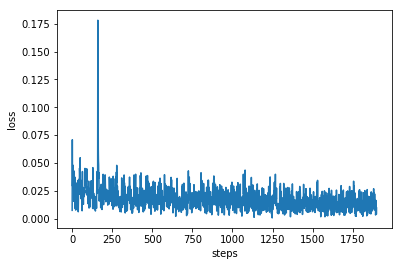

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
with open("resnext.txt") as f:
    train_losses = []
    a = [line.split() for line in f]
    for l in range(len(a)):
        if len(a[l]) > 0:
            if (a[l][0] == 'Train'):
                train_losses.append(float(a[l][-1]))
plt.plot(train_losses)
plt.ylabel('loss')
plt.xlabel('steps')
plt.show()              

## 50 epochs more!

In [13]:
optimizer = torch.optim.Adam(resnext.parameters())
sched = CosineAnnealingWarmRestarts(optimizer, T_0=1)
train_loop(resnext, train_dl, val_dl, optimizer, sched, epochs=50, exp_name='resnext_100_')

/home/rm5310/pyenv/py3.6.3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [0/388729 (0%)]	Loss: 0.016197
Train Epoch: 1 [10240/388729 (3%)]	Loss: 0.006071
Train Epoch: 1 [20480/388729 (5%)]	Loss: 0.027398
Train Epoch: 1 [30720/388729 (8%)]	Loss: 0.008390
Train Epoch: 1 [40960/388729 (11%)]	Loss: 0.022120
Train Epoch: 1 [51200/388729 (13%)]	Loss: 0.019819
Train Epoch: 1 [61440/388729 (16%)]	Loss: 0.010039
Train Epoch: 1 [71680/388729 (18%)]	Loss: 0.008299
Train Epoch: 1 [81920/388729 (21%)]	Loss: 0.007254
Train Epoch: 1 [92160/388729 (24%)]	Loss: 0.026400
Train Epoch: 1 [102400/388729 (26%)]	Loss: 0.010589
Train Epoch: 1 [112640/388729 (29%)]	Loss: 0.023779
Train Epoch: 1 [122880/388729 (32%)]	Loss: 0.007351
Train Epoch: 1 [133120/388729 (34%)]	Loss: 0.009986
Train Epoch: 1 [143360/388729 (37%)]	Loss: 0.012942
Train Epoch: 1 [153600/388729 (39%)]	Loss: 0.007705
Train Epoch: 1 [163840/388729 (42%)]	Loss: 0.020263
Train Epoch: 1 [174080/388729 (45%)]	Loss: 0.007973
Train Epoch: 1 [184320/388729 (47%)]	Loss: 0.014674
Train Epoch: 1 [194560/388729 

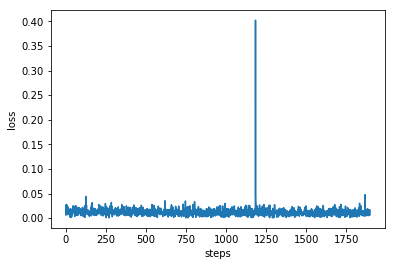

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
with open("resnext2.txt") as f:
    train_losses = []
    a = [line.split() for line in f]
    for l in range(len(a)):
        if len(a[l]) > 0:
            if (a[l][0] == 'Train'):
                train_losses.append(float(a[l][-1]))
plt.plot(train_losses)
plt.ylabel('loss')
plt.xlabel('steps')
plt.show()              

# All models now seemed to have converged enough so we'll now test with everything.

## Ensembling everything - Conv42, Multi-Scale CNN, Adaptive Multi-Scale CNN and Resnext50_32x4d

In [5]:
state_dict_1 = torch.load('Models/conv42_aug_100_100.pth')
model1 = Conv4Net().to(device)
model1.load_state_dict(state_dict_1)
model1.eval()

state_dict_2 = torch.load('Models/mcnn42_aug_500_100.pth')
model2 = MultiScaleCNN().to(device)
model2.load_state_dict(state_dict_2)
model2.eval()

state_dict_3 = torch.load('Models/amcnn1_32_100.pth')
model3 = AdaptiveMultiScaleCNN().to(device)
model3.load_state_dict(state_dict_3)
model3.eval()

state_dict_4 = torch.load('Models/amcnn1_50_50.pth')
model4 = AdaptiveMultiScaleCNN().to(device)
model4.load_state_dict(state_dict_4)
model4.eval()

state_dict_5 = torch.load('Models/amcnn1_70_50.pth')
model5 = AdaptiveMultiScaleCNN().to(device)
model5.load_state_dict(state_dict_5)
model5.eval()

state_dict_6 = torch.load('Models/resnext_100_50.pth')
model6 = resnext.to(device)
model6.load_state_dict(state_dict_6)
model6.eval()

exp_name = 'committee_42'

# Running all the test time augmentations on inputs of all three sizes 32x32, 50x50 and 70x70

In [8]:
t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11 = get_transforms(32)
t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t210,t211 = get_transforms(50)
t30,t31,t32,t33,t34,t35,t36,t37,t38,t39,t310,t311 = get_transforms(70)

test_dir = 'images/test_images'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

outfile = 'Output/'+exp_name+'_out.csv'

output_file = open(outfile, "w")
output_file.write("Filename,ClassId\n")
for f in tqdm(os.listdir(test_dir)):
    if 'ppm' in f:
        data1 = t211(pil_loader(test_dir + '/' + f))
        data2 = t21((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data3 = t22((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data4 = t23((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data5 = t24((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data6 = t25((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data7 = t26((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data8 = t27((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data9 = t28((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data10 = t29((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data11 = t210((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data12 = t20((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        
        final_input_1 = torch.cat((data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,data11,data12),0)
         
        ntrans, c, h, w = final_input_1.size()
        temp_output_1 = model1(Variable(final_input_1.view(-1, c, h, w)).to(device))
        temp_output_2 = model2(Variable(final_input_1.view(-1, c, h, w)).to(device))
        temp_output_3 = model4(Variable(final_input_1.view(-1, c, h, w)).to(device))
        temp_output_6 = model6(Variable(final_input_1.view(-1, c, h, w)).to(device))
        
        data21 = t11(pil_loader(test_dir + '/' + f))
        data22 = t1((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data23 = t2((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data24 = t3((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data25 = t4((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data26 = t5((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data27 = t6((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data28 = t7((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data29 = t8((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data210 = t9((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data211 = t10((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data212 = t0((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        
        final_input_2 = torch.cat((data21,data22,data23,data24,data25,data26,data27,data28,data29,data210,data211,data212),0)
         
        ntrans, c, h, w = final_input_2.size()
        temp_output_4 = model3(Variable(final_input_2.view(-1, c, h, w)).to(device))
        
        data31 = t311(pil_loader(test_dir + '/' + f))
        data32 = t31((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data33 = t32((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data34 = t33((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data35 = t34((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data36 = t35((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data37 = t36((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data38 = t37((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data39 = t38((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data310 = t39((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data311 = t310((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        data312 = t30((pil_loader(test_dir + '/' + f))).unsqueeze(0)
        
        final_input_3 = torch.cat((data31,data32,data33,data34,data35,data36,data37,data38,data39,data310,data311,data312),0)
         
        ntrans, c, h, w = final_input_3.size()
        temp_output_5 = model5(Variable(final_input_3.view(-1, c, h, w)).to(device))
        
        
        ensemble_res = torch.cat((temp_output_1, temp_output_2, temp_output_3,temp_output_4,temp_output_5, temp_output_6),0)
        output = ensemble_res.mean(0)
        pred = output.data.max(0, keepdim=True)[1]
    
        file_id = f[0:5]
        output_file.write("%s,%d\n" % (file_id, pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle '
      'competition at https://www.kaggle.com/c/nyu-cv-fall-2018/')
        

  0%|          | 0/12630 [00:00<?, ?it/s]/home/rm5310/pyenv/py3.6.3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 12630/12630 [17:38<00:00, 11.93it/s]

Succesfully wrote Output/committee_42_out.csv, you can upload this file to the kaggle competition at https://www.kaggle.com/c/nyu-cv-fall-2018/


# This got me my best accuracy on the public leaderboard of ~99.2%

### Further improvements:
1. Train the resnext for longer.
2. Add different kinds of resnets and wide-resnets which currently are the SoTA in ImageNet recognition.
3. Add more models to the ensemble (but don't think any more could fit in the 10GB limit in the GPUs)
4. Experiment with other augmentations.
5. Plot confusion matrix and see which classes are being misclassified most and train on them.

### References:
1. Traffic sign recognition with multi-scale Convolutional Networks - Sermanet, LeCun [http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf]
2. https://github.com/soumith/traffic-sign-detection-homework - Soumith Chintala
3. Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition - He, et.al [https://arxiv.org/pdf/1406.4729.pdf]
4. Deep Residual Learning for Image Recognition - He, et. al [https://arxiv.org/abs/1512.03385]
5. ImageNet Classification with Deep Convolutional Neural Networks - Krizhevsky, et.al [https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf]
6. Aggregated Residual Transformations for Deep Neural Networks - Xie, et.al [https://arxiv.org/pdf/1611.05431.pdf]
7. Torchvision transforms - [https://pytorch.org/docs/stable/torchvision/transforms.html]
8. Adam: A Method for Stochastic Optimization - Kingma et.al [https://arxiv.org/abs/1412.6980] 
9. Automatic differentiation in PyTorch - Paszke et. al [https://openreview.net/forum?id=BJJsrmfCZ] 
10. Stochastic Gradient Descent with warm restarts - Loshchilov et.al [https://arxiv.org/abs/1608.03983]

*Along with these references, I'd also like to mention the countless posts on the PyTorch discussion forums which helped me debug my models*